Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [ ]:
!pip install transformers

In [ ]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 16.0MB/s 


In [ ]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [ ]:
!pip install -q clean-text[gpl]

     |████████████████████████████████| 133kB 24.8MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 245kB 55.7MB/s 


In [ ]:
!pip install -q hazm

     |████████████████████████████████| 317kB 16.7MB/s 
     |████████████████████████████████| 1.4MB 54.1MB/s 
     |████████████████████████████████| 235kB 55.5MB/s 


In [ ]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report, accuracy_score

import hazm
from cleantext import clean


In [ ]:
# specify GPU
device = torch.device("cuda")

## Data

In [ ]:
data = pandas.read_excel('../labels.xlsx')
data = data.rename(columns={'labels': 'tag','text':'body'})
data = data.dropna().reset_index(drop=True)
data.head()

,Unnamed: 0,body
0,0,به عنوان یک برنامه نویس اندروید چطوری می توانی...
1,1,مهدی سادات حسینی دانشجو دوست کار دوست کامپیوتر...
2,2,کد مخف اندروید کد مخف اندروید اندروید کد کد پر...
3,3,با سلام خدمت شما خوانندگان عزیز تو این مطلب که...
4,4,حالا این که وقتی دیجیتال مارکتر به مانیتور خیر...


In [ ]:
# # counter
# count_data = data.copy()
# count_data = count_data.dropna().reset_index(drop=True)
# count = {}
# tags_list = pandas.read_excel('../Tags.xlsx',header = None)
# tags_list.columns = ['tag']
# for _,tag in tags_list.iterrows():
#   if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
#     count[re.sub(' ','',tag['tag'].lower())] = 0

# for indx,d in count_data.iterrows():
#   tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
#   for tag in tags:
#     if tag.strip().lower() in tags_list.values:
#       count[tag.strip().lower().replace(' ','')]+=1 
# # count

In [ ]:
# import  matplotlib.pyplot as plt
# plt.hist([count[k] for k in list(count.keys())])

In [ ]:
# data = data.dropna().reset_index(drop=True)
# data.head()

In [ ]:
data.shape

(3653, 2)

In [ ]:
# # counter 
# count_data = data.copy()
# count_data = count_data.dropna().reset_index(drop=True)
# count = {}
# tags_list = pandas.read_excel('../Tags.xlsx',header = None)
# tags_list.columns = ['tag']
# for _,tag in tags_list.iterrows():
#   if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
#     count[re.sub(' ','',tag['tag'].lower())] = 0

# for indx,d in count_data.iterrows():
#   tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
#   for tag in tags:
#     if tag.strip().lower() in tags_list.values:
#       count[tag.strip().lower().replace(' ','')]+=1 

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot([count[i] for i in list(count.keys())])

In [ ]:
# #All data befor pre-processing...
# print(data['body'])
# print(data.shape)
X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
# y=data["tag"].values.tolist()
# labels = []
# tag=[]
# for item in y:
#   labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
#   tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
# labels = list(set(labels))
# mlb = MultiLabelBinarizer()
# Y=mlb.fit_transform(tag)

In [ ]:
# for i in range(10):
#   print(X[i])
#   print(Y[i])

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning taxt
clean_x=[]
for t in X:
  clean_x.append(cleaning(t))


In [ ]:
for i in range(10):
  print(clean_x[i])

به عنوان یک برنامه نویس اندروید چطوری می‌توانید کارهایی کنید که باعث بالا بردن امنیت اندروید اپلیکیشن شما شود؟ اگر روش هایی بلد هستید که می‌تواند به شما در این زمینه کمک کند پس نسبت به رقبا یک قدم جلوتر هستید ولی اگر اطلااتی در این زمینه ندارید ما در این مقاله امنیت اندروید می‌خواهیم شما را با ۸ روش که بتوانید امنیت در سیستم عامل اندروید را بهبود ببخشید اشنا کنیم پس با این مقاله الکامکو در سایت ما همراه باشید سیستم عامل اندروید خودش دارای ویژگی‌های امنیتی داخلی زیادی است در نتیجه، برنامه‌های ساده اندرویدی که هیچگونه عملیات مربوط به\xa۰سیستم فایل یا عملیات شبکه را انجام نمی‌دهند، معمولا به طور پیش فرض امن در نظر گرفته می‌شوند ولی اگر در حال توسعه یک برنامه پیچیده‌تر هستید و مسیولیت امنیت ان را برعهده دارید و از حریم خصوصی کاربران محافظت می‌کنید پس حتما به موضوعاتی که در این مقاله اشاره شده توجه کنید چون در این مقاله امنیت اندروید قصد داریم تعدادی از بهترین روشهایی را که می‌تواند به ایمن کردن اپلیکیشن اندروید شما موقع ساخت ان کمک کند معرفی کنیم تا به طور کلی کمتر در برابر برنامه‌های مخرب

In [ ]:
# limit_number = 750
# data = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv',index_col=0)
# data = data.dropna().reset_index(drop=True)
# X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
# labels = []
# tag=[]
# for item in y['tag']:
#   labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
#   tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
# labels = list(set(labels))
# mlb = MultiLabelBinarizer()
# Y=mlb.fit_transform(tag)

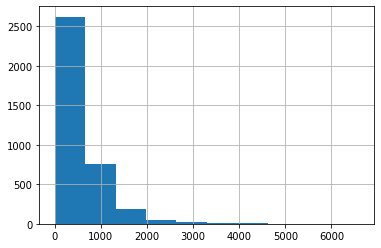

In [ ]:
seq_len = [len(i.split()) for i in clean_x]
pandas.Series(seq_len).hist(bins = 10)

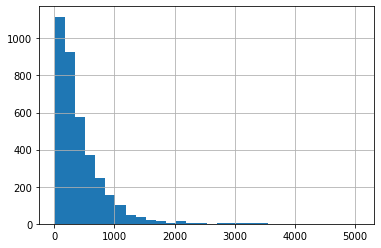

In [ ]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(clean_x,Y , test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
# print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

In [ ]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['کدنویسی', 'و', 'برنامه', 'نویسی', 'برای', 'تولید', 'انواع', 'نرم', 'افزار', 'کار', 'سادهای', 'محسوب', 'نمیشود', '،', 'اما', 'ارتش', 'امریکا', 'از', 'ابداع', 'هوش', 'مصنوعی', 'خاصی', 'برای', 'کدنویسی', 'نرم', 'افزارهای', 'جدید', 'خبر', 'داده', 'است', '.', 'به', 'گزارش', 'فیوچر', '##یسم', '،', 'bay', '##ou', 'نام', 'ابزار', 'هوش', 'مصنوعی', 'تازهای', 'است', 'که', 'مانند', 'یک', 'موتور', 'جستجوی', 'کدنویسی', 'عمل', 'میکند', '.', 'این', 'ابزار', 'ابتدا', 'از', 'شما', 'میپرسد', 'که', 'قصد', 'نگارش', 'چه', 'نوع', 'برنامه', 'و', 'نرم', 'افزاری', 'را', 'دارید', '.', 'بدین', 'منظور', 'کاربر', 'تنها', 'باید', 'چند', 'کلیدواژه', 'را', 'وارد', 'کند', 'و', 'سپس', 'bay', '##ou', 'کدهای', 'جاوای', '##ی', 'را', 'در', 'اختیار', 'شما', 'قرار', 'میدهد', 'که', 'میتوانند', 'نرم', 'افزار', 'مورد', 'نیازتان', 'را', 'در', 'اختیار', 'شما', 'قرار', 'دهند', '.', 'ابزار', 'یادشده', 'توسط', 'گروهی', 'از', 'محققان', 'علوم', 'رایانه', 'در', 'دانشگاه', 'رایس', 'ابداع', 'شده', 'و', 'تامین', 'بودجه', 'این', 'طرح', 'ت

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [ ]:
sent_id

{'input_ids': [[2, 39298, 1379, 3329, 12035, 2831, 3114, 4303, 5574, 7043, 2867, 12652, 4506, 4684, 1348, 2949, 4596, 3307, 2791, 10650, 4428, 7254, 4912, 2831, 39298, 5574, 16024, 3212, 3350, 3171, 2806, 1012, 2789, 3361, 55502, 8865, 1348, 28985, 11721, 2967, 4766, 4428, 7254, 9451, 2806, 2800, 3331, 2829, 4576, 8457, 39298, 3445, 2980, 1012, 2802, 4766, 4309, 2791, 3124, 17167, 2800, 4790, 9066, 3051, 3645, 3329, 1379, 5574, 11378, 2803, 4717, 1012, 5362, 4297, 5988, 3327, 3013, 3102, 41305, 2803, 3332, 3054, 1379, 3854, 28985, 11721, 13197, 87205, 2003, 2803, 2786, 4209, 3124, 2959, 3238, 2800, 3918, 5574, 7043, 3050, 33617, 2803, 2786, 4209, 3124, 2959, 4577, 1012, 4766, 13730, 3158, 5382, 2791, 7125, 4458, 8285, 2786, 3363, 31315, 10650, 2871, 1379, 3823, 4925, 2802, 3512, 7957, 3158, 5934, 1379, 4596, 3307, 3080, 3296, 2806, 1012, 28985, 11721, 2831, 5574, 7043, 12035, 13197, 5392, 11668, 3329, 10937, 2803, 3640, 1379, 7060, 1379, 4683, 2980, 2800, 8203, 2791, 4334, 3399, 3295, 

In [ ]:
sentence_maxlen=128

In [ ]:
##Tokenize training and validation sentences:
# train_encodings = tokenizer.batch_encode_plus(X_train,
#     max_length = sentence_maxlen,
#     truncation=True,
#     add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#     return_token_type_ids=True,
#     return_attention_mask=True,
#     padding='max_length',
#     return_tensors='pt',  # Return PyTorch tensors
#     )

# val_encodings = tokenizer.batch_encode_plus(X_val,
#     max_length = sentence_maxlen,
#     truncation=True,
#     add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#     return_token_type_ids=True,
#     return_attention_mask=True,
#     padding='max_length',
#     return_tensors='pt',  # Return PyTorch tensors
#     )

test_encodings=tokenizer.batch_encode_plus(clean_x,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

In [ ]:
# train_encodings[0]

In [ ]:
import torch
import torch.nn as nn

# # for train set
# train_seq = torch.tensor(train_encodings['input_ids'])
# train_mask = torch.tensor(train_encodings['attention_mask'])
# train_y = torch.FloatTensor(y_train)

# # for validation set
# val_seq = torch.tensor(val_encodings['input_ids'])
# val_mask = torch.tensor(val_encodings['attention_mask'])
# val_y = torch.FloatTensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.FloatTensor(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [ ]:
# train_y[0]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# #define a batch size
# batch_size = 32

# # wrap tensors
# train_data = TensorDataset(train_seq, train_mask, train_y)

# # sampler for sampling the data during training
# train_sampler = RandomSampler(train_data)

# # dataLoader for train set
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# # wrap tensors
# val_data = TensorDataset(val_seq, val_mask, val_y)

# # sampler for sampling the data during training
# val_sampler = SequentialSampler(val_data)

# # dataLoader for validation set
# val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# example


# text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# # encode text
# sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
# print(sent_id)

# seq = torch.tensor(sent_id['input_ids'])
# mask = torch.tensor(sent_id['attention_mask'])
# train_y = torch.tensor([0,1])

# transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
# cls_hs=transformer_model(seq,mask)
# print(cls_hs)
# print(cls_hs[0])
# print(cls_hs[1])
# print(cls_hs[1].shape)
# print(cls_hs[0].shape)

In [ ]:
# model = BERT_Arch(transformer_model)
# model = model.to(device)
# for step,batch in enumerate(train_dataloader):
    
#     # progress update after every 50 batches.
#     if step % 50 == 0 and not step == 0:
#       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

#     # push the batch to gpu
#     batch = [r.to(device) for r in batch]
#     sent_id, mask, labels = batch
#     preds = model(sent_id,mask)
#     break

In [ ]:
# loss_func=nn.BCELoss(weight=class_weight)
# loss_func = nn.CrossEntropyLoss(weight=class_weight)
# loss=loss_func(preds.float(),labels.float())
    
# loss.backward()

## Model

In [ ]:
transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False
    

In [ ]:
classnum=len(labels)
classnum

80

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      self.bn_1 = nn.BatchNorm1d(768)

      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      # self.relu =  nn.ReLU()
      self.elu =  nn.ELU()

      self.tanh=nn.Tanh()


      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      self.bn_2 = nn.BatchNorm1d(512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,classnum)

      self.bn_2 = nn.BatchNorm1d(classnum)

      #sigmoid activation function
      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.bn_1(cls_hs[1])

      x = self.fc1(x)
      
      x = self.elu(x)

      # x = self.tanh(x)

      # print("after fc1:",x)

      x = self.dropout(x)

      # print("after fc1 drop out:",x)
      # output layer
      x = self.fc2(x)

      x = self.bn_2(x)
      # print("after fc2:",x)
      # apply sigmoid activation
      x = self.sigmoid(x)
      # print("after fc2 sigmoid:",x)
      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
# # optimizer from hugging face transformers
# from transformers import AdamW


# # define the optimizer
# optimizer = AdamW(model.parameters(), lr = 1e-3)
# # optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [ ]:
# ##Calculating weights 
# class_counts=[0]*classnum
# for cl in Y:
#     #  print(cl)
#      for i in range(classnum):
#       #  print(i)
#        if cl[i]==1:
#           class_counts[i]+=1
# print(class_counts)

# weight=[]
# for indx in range(classnum):
#   weight.append(((class_counts[indx]/len(Y))))

# print(weight)

# # class_weight= torch.tensor(weight,dtype=torch.float)
# class_weight = torch.FloatTensor(weight)
# class_weight = class_weight.to(device)
# print(class_weight)

In [ ]:
# # loss_func =nn.MultiLabelMarginLoss()
# # loss_func=nn.BCEWithLogitsLoss(weight=class_weight)
# loss_func=nn.BCELoss(weight=class_weight)
# # loss_func = nn.CrossEntropyLoss(weight=class_weight)
# # loss_func=nn.NLLLoss(weight=class_weight)

In [ ]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
preds = model(test_seq, test_mask)

RuntimeError: ignored

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss=loss_func(preds,labels)
    
    # loss=0
      
    # for b in range(batch_size):
    #   for l in range(classnum):
    #     print(preds[b][l], labels[b][l])
    #     loss += loss_func(preds[b][l], labels[b][l])

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      
      # compute the validation loss between actual and predicted values

      # loss=0
      # for b in range(batch_size):
      #   for l in range(classnum):
      #     loss += loss_func(preds[b][l], labels[b][l])
      
      loss=loss_func(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# number of training epochs
epochs = 30

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
  Batch    50  of    669.
  Batch   100  of    669.
  Batch   150  of    669.
  Batch   200  of    669.
  Batch   250  of    669.
  Batch   300  of    669.
  Batch   350  of    669.
  Batch   400  of    669.
  Batch   450  of    669.
  Batch   500  of    669.
  Batch   550  of    669.
  Batch   600  of    669.
  Batch   650  of    669.

Evaluating...
  Batch    50  of    223.
  Batch   100  of    223.
  Batch   150  of    223.
  Batch   200  of    223.

Training Loss: 0.013
Validation Loss: 0.010

 Epoch 2 / 30
  Batch    50  of    669.
  Batch   100  of    669.
  Batch   150  of    669.
  Batch   200  of    669.
  Batch   250  of    669.
  Batch   300  of    669.
  Batch   350  of    669.
  Batch   400  of    669.
  Batch   450  of    669.
  Batch   500  of    669.
  Batch   550  of    669.
  Batch   600  of    669.
  Batch   650  of    669.

Evaluating...
  Batch    50  of    223.
  Batch   100  of    223.
  Batch   150  of    223.
  Batch   200  of    223.

Training L

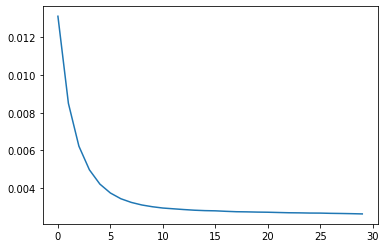

In [ ]:
plt.plot(train_losses)

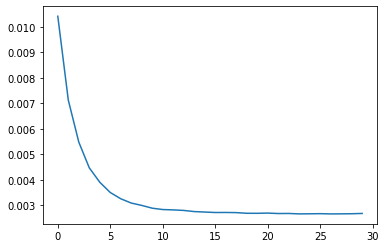

In [ ]:
plt.plot(valid_losses)

Loading saved model:

In [ ]:
# torch.save(model.state_dict(), 'ParsBERT_pytorch_weighted_0.pt')

# # torch.cuda.empty_cache()
# # pass the pre-trained BERT to our define architecture
# model = BERT_Arch(transformer_model)

# # push the model to GPU
# model = model.to(device)

In [ ]:
# #load weights of best model
# pass the pre-trained BERT to our define architecture
model_2 = BERT_Arch(transformer_model)

# push the model to GPU
model_2 = model_2.to(device)
path = 'ParsBERT_pytorch_weighted_0.pt'
model_2.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
for param in model.parameters():
  print(param)

Streaming output truncated to the last 5000 lines.
        -1.0485e-02, -1.9564e-02, -1.0057e-02, -1.1514e-01,  5.5204e-02,
        -5.9053e-02, -8.3930e-02,  9.4068e-02, -8.0703e-02, -4.5830e-02,
         9.7133e-03, -8.1481e-02, -5.0204e-02,  3.2661e-02,  6.1303e-03,
        -7.0081e-02,  4.5256e-02,  1.1016e-02,  8.7762e-02,  8.3100e-02,
         1.3273e-01, -5.0298e-02, -1.4383e-01,  4.6895e-02,  9.1825e-02,
         1.2186e-02, -6.6019e-02,  3.7311e-02,  3.9128e-02, -2.0130e-02,
         2.8679e-02, -2.7021e-02, -3.1071e-02, -3.8980e-05,  6.9615e-02,
         2.3728e-02,  2.9275e-02,  7.6898e-02, -1.7602e-03,  3.0784e-02,
         1.0827e-03,  6.8736e-02, -4.2639e-02,  6.3576e-03,  5.2727e-02,
        -7.6796e-02,  7.2382e-02,  9.0578e-04,  6.5198e-02,  4.2219e-01,
         4.8358e-03, -1.0172e-01, -1.1578e-03, -5.9929e-02,  6.8960e-02,
         9.8838e-02, -6.5991e-02,  6.8015e-02, -2.2219e-02,  6.3356e-02,
         8.8956e-02, -4.5607e-02, -1.8060e-02, -5.2605e-02, -9.8390e-02,


After loading model:

In [ ]:
y_pred=[]
y_true=[]
for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      # outputs_before_sigmoid = model(sent_id, mask)
      preds = model(sent_id, mask)
      # print(preds)
      # print(preds.cpu().numpy())
      
      
      # outputs_before_sigmoid = outputs_before_sigmoid.cpu().numpy()
      # model's performance
    # preds = numpy.argmax(preds, axis = 1)
    # print(len(preds),len(preds[0]))
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # print(measure)


    # preds=[]
    # for l in range(len(outputs_before_sigmoid)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # for l in range(len(outputs_before_sigmoid)):
    #   temp=[]
    #   for value in preds:
    #     if value >= measure:
    #       temp.append(1)
          
    #     else:
    #       temp.append(0)
    #   y_pred.append(temp)
    #   y_true.append(labels.cpu().numpy()[l])
    #   # print( preds[l])
    #   print("temp:",(temp))
    #   print("labels:",labels.cpu().numpy()[l])
    
    # print(labels.cpu().numpy()[0], preds[0])
  

    # for l in range(len(preds)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    preds = preds.cpu().numpy()
    measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    for l in range(len(preds)):
      temp=[]
      for value in preds[l]:
        if value >= measure:
          temp.append(1)
          
        else:
          temp.append(0)
      y_pred.append(temp)
      y_true.append(labels.cpu().numpy()[l])
      print( preds[l])
      print("temp:",(temp))
      print("labels:",labels.cpu().numpy()[l])

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Streaming output truncated to the last 5000 lines.
temp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.]
[0.02354838 0.02586172 0.04412846 0.00072753 0.02868097 0.00955757
 0.00724912 0.00275451 0.00190396 0.00183824 0.01316911 0.00701228
 0.006973   0.00543602 0.0035979  0.00367155 0.00395696 0.01612355
 0.00582238 0.00445423 0.12824424 0.0058285  0.00415889 0.00272067
 0.00639949 0.00475434 0.00073501 0.03268759 0.00247826 0.00385702
 0.00297025 0.1403157  0.0112053  0.00094982 0.00116942 0.00711424
 0.03057332 0.00284388 0.00400354 0.51564014 0.

In [173]:
pred_df =  pandas.read_csv('FineTuning_result.csv')
pred = pred_df.values
y_pred=[]
measure = numpy.mean(pred[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
for l in range(len(pred)):
  temp=[]
  for value in pred[l]:
    if value >= measure:
      temp.append(1)
    else:
      temp.append(0)
  y_pred.append(temp)
  


y_pred_df =  pandas.DataFrame(y_pred)
y_pred_df.to_csv('FineTuning.csv')

In [176]:
y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [177]:
y_pred_df.to_csv('FineTuning.csv')

(3653, 81)